# Introducción Modelos offline
A continuación utilizaremos el fichero creado anteriormente a partir del enviroment de recsim  de Interest Rate con DQN para evaluar diferentes modelos offline. Los modelos offline permiten, a partir de información de interacciones de usuario, generar un modelo de RL. En este caso, la principal diferencial con los modelos online es que no tienes el feedback directo del usuario a partir de las acciones realizadas. Para intentar trabajar con este problema, los modelos DQN asigna una probabilidad asociada a cada interacción que es utilizada con estos modelos.

<a id='model_pick'></a>
## Modelos offline de RL
RLlib tiene una gran cantidad de modelos offline que pueden ser utilizados para entrenar un modelo a partir de un fichero con interacciones del usuario con los productos.  Los modelos que veremos serán los siguientes:


- Behavior Cloning model (BC)
- Marwil
Para estos utilizaremos métricas offline ImportanceSampling y WeightedImportanceSampling.

Se han probado otros pero debido a la multi-dimensionalidad de este caso de uso, no eran válidos.

# Flujo
1. Se cargan los datos guardados en json del modelo DQN con el entorno InterestEvolution
2. Se genera el modelo BCTrainer con estos datos 
3. Se persiste este modelo para posteriormente levantar una API rest con el mismo
4. Se genera el modelo Marwil




<a id='recsim'></a>
# Librería recsim, entorno de RL

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Librerías estandar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from progressbar import ProgressBar
import os
# librerias para RL
import ray
from ray import tune
## environment
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv, InterestEvolutionRecSimEnv
## agentes
from ray.rllib.agents.cql import CQLTrainer, CQL_DEFAULT_CONFIG
from ray.rllib.agents.marwil import MARWILTrainer, MARWILConfig
from ray.rllib.agents.marwil import BCTrainer, BCConfig # derivado del MARWIL
from ray.rllib.offline.estimators import (
    ImportanceSampling,
    WeightedImportanceSampling,
    DirectMethod,
    DoublyRobust,
)
#from ray.rllib.offline.estimators.fqe_torch_model import FQETorchModel


import gym  # RL environments and action/observation spaces




C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\Users\Paul\AppData\Roa

In [3]:
# cargamos las funciones que hemos guardado dentro de la carpeta src
# nos permite compartir funciones en diferentes notebooks
import sys
sys.path.append('../src')
from models.rlmodels import  run_rlmodel_episode, run_simulation, run_rlmodel_episode_offline 
from visualization.visualize import plot_rewards_timestamp
from data.env import LTSWithStrongerDissatisfactionEffect 
from utils.docs import get_json_files

# Environment
A continuación vemos como es el entorno sobre el que vamos a entrenar nuestro agente

In [4]:
SEED = 0

## configuración del entorno: 20 posibles candidatos del que seleccionaremos 2
# mantendremos esta configuración para los demás agentes también
NUM_CANDIDATES = 20
SLATE_SIZE = 2
REGISTER_ENV_NAME = "env_ie"

# Load
Cargamos el fichero de long Interest Rate para utilizarlo posteriormente con los modelos offline. Usaremos el generado por el DQN con el entorno Interest Rate.

In [5]:
#OUTPUT_DIR = "C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data"
json_output_file = "C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data\\output-2022-09-01_17-40-45_worker-0_1.json"
json_output_file

'C:\\Users\\Paul\\ray_results\\DQN_2022-09-01_17-40-13\\DQN_env_ie_5e8d7_00000_0_2022-09-01_17-40-13\\data\\output-2022-09-01_17-40-45_worker-0_1.json'

Cargamos el entorno que utilizaremos del modelo offline y que nos permitirá a posteriori añadir información a los modelos offline

In [6]:
offline_rl_env = InterestEvolutionRecSimEnv({
    "num_candidates": NUM_CANDIDATES,
    "slate_size": SLATE_SIZE,
    'resample_documents': False, # si resampleamos los documentos en cada episodio

    "wrap_for_bandits": False,  # SlateQ != Bandit
    "convert_to_discrete_action_space": True,
     "wrap_for_bandits": True,  
})



In [7]:
df = pd.read_json(json_output_file,lines=True)
df.head()

,type,obs,new_obs,actions,prev_actions,rewards,prev_rewards,dones,infos,t,eps_id,unroll_id,agent_index,q_values,action_dist_inputs,action_logp,action_prob,weights
0,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[258, 58, 374, 55]","[364, 258, 58, 374]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[47, 48, 49, 50]","[1109658755, 1109658755, 1109658755, 1109658755]","[1027, 1027, 1027, 1027]","[0, 0, 0, 0]","[[15.685279846191406, 15.421998977661133, 14.0...","[[15.685279846191406, 15.421998977661133, 14.0...","[-7.300140380859375, -4.897860527038574, -5.33...","[0.000675443967338, 0.007462531793862001, 0.00...","[1.0, 1.0, 1.0, 1.0]"
1,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[226, 48, 197, 55]","[55, 226, 48, 197]","[4.0, 0.0, 4.0, 4.0]","[0.0, 4.0, 0.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[51, 52, 53, 54]","[1109658755, 1109658755, 1109658755, 1109658755]","[1028, 1028, 1028, 1028]","[0, 0, 0, 0]","[[15.557333946228027, 15.320795059204102, 13.9...","[[15.557333946228027, 15.320795059204102, 13.9...","[-3.9688994884490962, -4.296158790588379, -5.2...","[0.018894214183092003, 0.013620778918266001, 0...","[1.0, 1.0, 1.0, 1.0]"
2,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[181, 92, 142, 116]","[55, 181, 92, 142]","[0.0, 0.0, 0.0, 0.0]","[4.0, 0.0, 0.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[55, 56, 57, 58]","[1109658755, 1109658755, 1109658755, 1109658755]","[1029, 1029, 1029, 1029]","[0, 0, 0, 0]","[[15.255053520202637, 15.05372428894043, 13.70...","[[15.255053520202637, 15.05372428894043, 13.70...","[-5.065549850463867, -6.6923322677612305, -5.5...","[0.006310440134257, 0.001240386511199, 0.00381...","[1.0, 1.0, 1.0, 1.0]"
3,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[165, 174, 119, 225]","[116, 165, 174, 119]","[0.0, 4.0, 0.0, 0.0]","[0.0, 0.0, 4.0, 0.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[59, 60, 61, 62]","[1109658755, 1109658755, 1109658755, 1109658755]","[1030, 1030, 1030, 1030]","[0, 0, 0, 0]","[[14.899430274963379, 14.733202934265137, 13.3...","[[14.899430274963379, 14.733202934265137, 13.3...","[-6.127820491790771, -6.252415180206299, -5.24...","[0.002181329997256, 0.0019257973181080002, 0.0...","[1.0, 1.0, 1.0, 1.0]"
4,SampleBatch,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,BCJNGGhAgRkAAAAAAAB4VQIAAGGABZV2GQABAPMZjBJudW...,"[48, 24, 149, 128]","[225, 48, 24, 149]","[0.0, 4.0, 4.0, 0.0]","[0.0, 0.0, 4.0, 4.0]","[False, False, False, False]",[{'env': '<recsim.simulator.environment.Single...,"[63, 64, 65, 66]","[1109658755, 1109658755, 1109658755, 1109658755]","[1031, 1031, 1031, 1031]","[0, 0, 0, 0]","[[14.712350845336914, 14.580305099487305, 13.2...","[[14.712350845336914, 14.580305099487305, 13.2...","[-4.484161376953125, -5.423988342285156, -5.00...","[0.011286348104476, 0.004409524612128, 0.00669...","[1.0, 1.0, 1.0, 1.0]"


In [8]:
df.shape

(1028, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type                1028 non-null   object
 1   obs                 1028 non-null   object
 2   new_obs             1028 non-null   object
 3   actions             1028 non-null   object
 4   prev_actions        1028 non-null   object
 5   rewards             1028 non-null   object
 6   prev_rewards        1028 non-null   object
 7   dones               1028 non-null   object
 8   infos               1028 non-null   object
 9   t                   1028 non-null   object
 10  eps_id              1028 non-null   object
 11  unroll_id           1028 non-null   object
 12  agent_index         1028 non-null   object
 13  q_values            1028 non-null   object
 14  action_dist_inputs  1028 non-null   object
 15  action_logp         1028 non-null   object
 16  action_prob         1028

## Análisis de los datos offline

In [10]:
cols = ["eps_id","unroll_id","actions","prev_actions","t","rewards","prev_rewards","action_prob","q_values","dones"]
df_exp = df[cols].apply(pd.Series.explode).reset_index()
cols_to_float = ["rewards","prev_rewards","action_prob","dones"]
df_exp[cols_to_float] = df_exp[cols_to_float].astype("float")
cols_to_cat = ["eps_id","unroll_id"]
df_exp[cols_to_cat] = df_exp[cols_to_cat].astype("category")
df_exp.head()


,index,eps_id,unroll_id,actions,prev_actions,t,rewards,prev_rewards,action_prob,q_values,dones
0,0,1109658755,1027,258,364,47,0.0,0.0,0.000675,"[15.685279846191406, 15.421998977661133, 14.08...",0.0
1,0,1109658755,1027,58,258,48,0.0,0.0,0.007463,"[15.685279846191406, 15.421998977661133, 14.08...",0.0
2,0,1109658755,1027,374,58,49,0.0,0.0,0.004835,"[15.685279846191406, 15.421998977661133, 14.08...",0.0
3,0,1109658755,1027,55,374,50,0.0,0.0,0.006941,"[15.685279846191406, 15.421998977661133, 14.08...",0.0
4,1,1109658755,1028,226,55,51,4.0,0.0,0.018894,"[15.557333946228027, 15.320795059204102, 13.97...",0.0


In [11]:
df_exp.describe(include="all")

,index,eps_id,unroll_id,actions,prev_actions,t,rewards,prev_rewards,action_prob,q_values,dones
count,4112.000000,4.112000e+03,4112.0,4112.0,4112.0,4112.0,4112.000000,4112.000000,4112.000000,4112,4112.000000
unique,NaN,5.000000e+01,1065.0,399.0,399.0,126.0,NaN,NaN,NaN,1028,NaN
top,NaN,1.403117e+09,1027.0,226.0,226.0,47.0,NaN,NaN,NaN,"[15.685279846191406, 15.421998977661133, 14.08...",NaN
freq,NaN,1.260000e+02,4.0,37.0,37.0,50.0,NaN,NaN,NaN,4,NaN
mean,513.500000,NaN,NaN,NaN,NaN,NaN,1.815730,1.815894,0.003493,NaN,0.011916
std,296.793989,NaN,NaN,NaN,NaN,NaN,1.985049,1.989525,0.002181,NaN,0.108523
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000139,NaN,0.000000
25%,256.750000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.002083,NaN,0.000000
50%,513.500000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.002974,NaN,0.000000
75%,770.250000,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000,0.004259,NaN,0.000000


Por lo que vemos, tenemos un total de 399 acciones diferentes, un total de 50 episodios diferentes con hasta 126 timesteps. 

El máximo reward es de 4, mientras que el mínimo como es lógico es de 0. El promedio se sitúa en 1.81.

Text(0.5, 1.0, 'histograma de action prob')

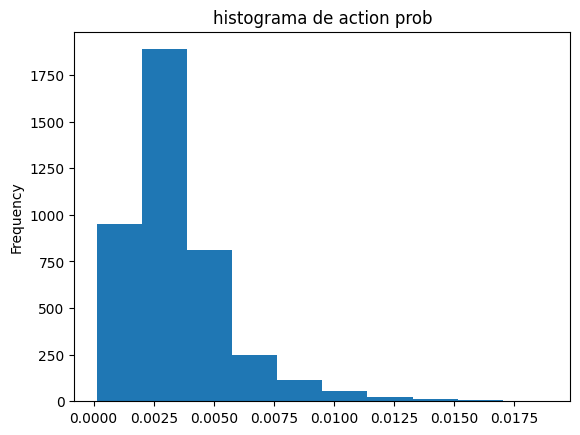

In [12]:
df_exp.action_prob.plot(kind="hist")
plt.title("histograma de action prob")

Veamos cuales son los rewards promedio de las acciones

In [13]:
actionsbyrew = df_exp.groupby("actions").rewards.agg(["mean","count"])
actionsbyrew = actionsbyrew[((actionsbyrew["count"]>12))]
actionsbyrew.sort_values("mean",ascending=False)

,mean,count
actions,,
95,2.571429,14
204,2.571429,14
92,2.526316,19
82,2.526316,19
106,2.500000,24
...,...,...
185,1.000000,20
237,1.000000,16
350,0.923077,13


Text(0.5, 1.0, 'histograma de medias de rewards por acción para acciones con más de 12 ocurrencias')

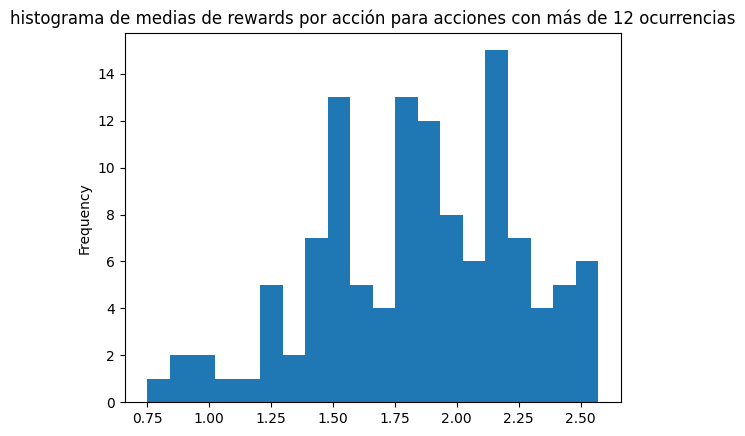

In [14]:
actionsbyrew["mean"].plot(kind="hist",bins=20)
plt.title("histograma de medias de rewards por acción para acciones con más de 12 ocurrencias")

Veamos ahora si el reward suele ser cero para una determinada acción.

Text(0.5, 1.0, 'Porcentaje de rewards nulos por acción')

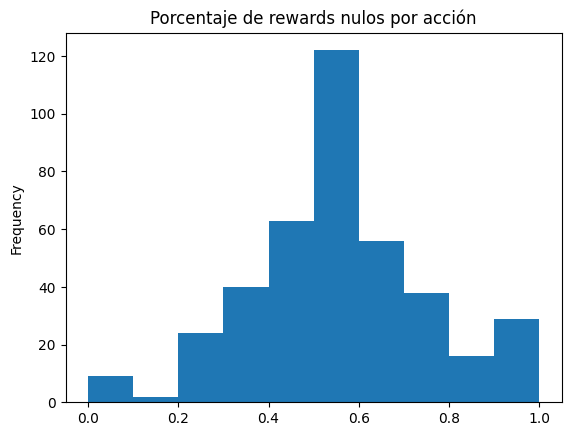

In [15]:
df_exp.groupby("actions").rewards.agg(lambda x: sum(x==0)/len(x)).plot(kind="hist")
plt.title("Porcentaje de rewards nulos por acción")

Vemos aquí que cada acción suele tener alrededor de un 50% de rewards nulos y el otro positivos mayores que cero.

## BC Trainer

A continuación configuramos un nuevo trainer de RLlib offline a partir del Config que nos proporciona la librería.

In [16]:
MODEL_NAME = "BCTrainer"
config = (
    BCConfig()
    .environment(env=None)
    .framework("torch")
    .offline_data(input_=[json_output_file])
    .evaluation(
        evaluation_interval=1,
        evaluation_duration=10,
        evaluation_num_workers=1,
        evaluation_duration_unit="episodes",
        evaluation_config={"input": [json_output_file]},
        off_policy_estimation_methods={
            "is": {"type": ImportanceSampling},
            "wis": {"type": WeightedImportanceSampling},
           
            },
        #},
    )
)
# hemos puesto en env a None por lo que tenemos que darle esta info al modelo offline
config.observation_space = offline_rl_env.observation_space 
config.action_space = offline_rl_env.action_space
bc_trainer = config.build()

2022-09-07 19:14:29,991	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-07 19:14:33,055	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2022-09-07 19:14:35,597	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-07 19:14:35,598	WARNING deprecation.py:47 -- DeprecationWarning: 

En este caso recordemos que no vamos a tener rewards, debido a que no tenemos un entorno que devuelve estos valores en función de las interacciones desarrolladas por el agente. Por ello es necesario utilizar métricas diferentes.

In [17]:
for _ in range(10):
    results = bc_trainer.train()
    print(f"{results['info']['num_agent_steps_trained']} steps trained; loss = {results['info']['learner']['default_policy']['learner_stats']['total_loss']};  reward = {results['episode_reward_mean']}")

2022-09-07 19:14:42,103	WARNING multi_agent_prioritized_replay_buffer.py:220 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
2022-09-07 19:14:42,154	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


2000 steps trained; loss = 5.991583347320557;  reward = nan
4000 steps trained; loss = 5.990262031555176;  reward = nan
6000 steps trained; loss = 5.9885783195495605;  reward = nan
8000 steps trained; loss = 5.987313747406006;  reward = nan
10000 steps trained; loss = 5.985818862915039;  reward = nan
12000 steps trained; loss = 5.985288143157959;  reward = nan
14000 steps trained; loss = 5.982832908630371;  reward = nan
16000 steps trained; loss = 5.981958866119385;  reward = nan
18000 steps trained; loss = 5.980355262756348;  reward = nan
20000 steps trained; loss = 5.9790849685668945;  reward = nan


## Estimadores Offpolicy

In [18]:
results.keys()

dict_keys(['evaluation', 'custom_metrics', 'episode_media', 'num_recreated_workers', 'info', 'sampler_results', 'episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter', 'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'hist_stats', 'sampler_perf', 'num_faulty_episodes', 'num_healthy_workers', 'num_agent_steps_sampled', 'num_agent_steps_trained', 'num_env_steps_sampled', 'num_env_steps_trained', 'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter', 'timesteps_total', 'num_steps_trained_this_iter', 'agent_timesteps_total', 'timers', 'counters', 'done', 'episodes_total', 'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'timesteps_since_restore', 'iterations_since_restore', 'warmup_time', 'perf'])

In [19]:
ope_results = results["evaluation"]['off_policy_estimator']
print(f"IS off-policy estimation: {ope_results['is']}")
print(f"WIS off-policy estimation: {ope_results['wis']}")

IS off-policy estimation: {'v_behavior': 102.3383017289212, 'v_target': 44.14496476188912, 'v_gain': 0.42704408333225574, 'v_behavior_std': 13.475497117477964, 'v_target_std': 96.4118103744495, 'v_gain_std': 0.9200240622790525}
WIS off-policy estimation: {'v_behavior': 102.3383017289212, 'v_target': 109.53257933587192, 'v_gain': 1.0553813170580824, 'v_behavior_std': 13.475497117477964, 'v_target_std': 273.10457277231893, 'v_gain_std': 2.5804536238792055}


In [20]:
ope_results

{'is': {'v_behavior': 102.3383017289212,
  'v_target': 44.14496476188912,
  'v_gain': 0.42704408333225574,
  'v_behavior_std': 13.475497117477964,
  'v_target_std': 96.4118103744495,
  'v_gain_std': 0.9200240622790525},
 'wis': {'v_behavior': 102.3383017289212,
  'v_target': 109.53257933587192,
  'v_gain': 1.0553813170580824,
  'v_behavior_std': 13.475497117477964,
  'v_target_std': 273.10457277231893,
  'v_gain_std': 2.5804536238792055}}

Ejecución del modelo

In [21]:
NUM_EPISODES = 100
results = run_simulation(bc_trainer,num_episodes = NUM_EPISODES, func = run_rlmodel_episode_offline)

100%|██████████| 100/100 [17:46<00:00, 10.67s/it]


In [22]:
def get_offline_metrics(results,model=None):
    iss,wiss, losses=[], [], []
    for result in results:
        if type(result) == list:
            
            for r in result:
                losses.append(r["loss"])
                iss.append(r["is"])
                wiss.append(r["wis"])
    is_df = pd.DataFrame(iss).rename_axis('num_episode').assign(offline_method="IS")
    wis_df = pd.DataFrame(wiss).rename_axis('num_episode').assign(offline_method="WIS")
    loss_df = pd.Series(losses).rename("loss").to_frame().rename_axis('num_episode').assign(offline_method="loss") 
    print(wis_df)

    return pd.concat([is_df, wis_df, loss_df],axis=0).assign(model=model)


In [23]:
offline_metrics = get_offline_metrics(results,model = MODEL_NAME)

             v_behavior    v_target    v_gain  v_behavior_std  v_target_std  \
num_episode                                                                   
0            102.619356  109.860911  1.056171       13.247511    277.168004   
1            102.522018  111.636285  1.073791       13.163751    280.753526   
2            102.443820  113.116084  1.091627       12.887895    284.772248   
3            102.546519  105.273605  1.012237       12.869636    265.886995   
4            102.667207  116.807887  1.125806       13.466870    293.475629   
...                 ...         ...       ...             ...           ...   
95           102.244301  193.563980  1.889462       13.787538    334.571092   
96           102.539844  196.712414  1.923835       13.427833    346.751466   
97           102.597601  199.029239  1.947145       12.676190    348.877395   
98           102.383575  198.605932  1.954701       12.914697    345.509266   
99           102.360530  193.158812  1.890828       

In [24]:
offline_metrics

,v_behavior,v_target,v_gain,v_behavior_std,v_target_std,v_gain_std,offline_method,loss,model
num_episode,,,,,,,,,
0,102.619356,44.589592,0.430231,13.247511,99.109281,0.945160,IS,NaN,BCTrainer
1,102.522018,45.576417,0.439783,13.163751,101.885906,0.972123,IS,NaN,BCTrainer
2,102.443820,46.207327,0.447364,12.887895,104.715011,0.999050,IS,NaN,BCTrainer
3,102.546519,43.836962,0.423185,12.869636,98.521348,0.936920,IS,NaN,BCTrainer
4,102.667207,48.482176,0.468552,13.466870,110.682821,1.055533,IS,NaN,BCTrainer
...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,loss,5.887479,BCTrainer
96,NaN,NaN,NaN,NaN,NaN,NaN,loss,5.887630,BCTrainer
97,NaN,NaN,NaN,NaN,NaN,NaN,loss,5.882698,BCTrainer


Persistencia del modelo (también en ray results)

In [25]:
checkpoint_dir = f"../models/offline_rl/interest_evolution/{MODEL_NAME}"
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = bc_trainer.save(checkpoint_dir)
print(f"Trainer en iteración {bc_trainer.iteration} guardado en '{checkpoint_file}'.")
offline_metrics.to_csv(os.path.join(checkpoint_dir,"offline_metrics.csv"))

Trainer en iteración 110 guardado en '../models/offline_rl/interest_evolution/BCTrainer\checkpoint_000110'.


Probamos a restaurar el modelo

In [26]:
new_bc_trainer = config.build()
# Pretend, we wanted to pick up training from a previous run:
# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_bc_trainer.iteration}")
new_bc_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_bc_trainer.iteration}")

2022-09-07 19:34:17,531	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-07 19:34:17,550	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-07 19:34:17,551	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will 

Before restoring: Trainer is at iteration=0
After restoring: Trainer is at iteration=110


Marwil model

A continuación ejecutaremos el modelo marwil y evaluaremos su performance

In [27]:
MODEL_NAME = "MARWILTrainer"
config_marwil = (
    MARWILConfig()
    .environment(env=None)
    #.framework("torch")
    .offline_data(input_=[json_output_file])
    .evaluation(
        evaluation_interval=1,
        evaluation_duration=10,
        evaluation_num_workers=1,
        evaluation_duration_unit="episodes",
        evaluation_config={"input": [json_output_file]},
        off_policy_estimation_methods={
            "is": {"type": ImportanceSampling},
            "wis": {"type": WeightedImportanceSampling},
           
            },
        #},
    )
)


# hemos puesto en env a None por lo que tenemos que darle esta info al modelo offline
config_marwil.observation_space = offline_rl_env.observation_space 
config_marwil.action_space = offline_rl_env.action_space
config_marwil.lr = 0.000000001
config_marwil.grad_clip = 10.0
config_marwil.vf_coeff = 0.001
marwil_trainer = config_marwil.build()

2022-09-07 19:34:23,123	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-07 19:34:23,824	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-07 19:34:23,825	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will 

In [28]:
NUM_EPISODES = 100
results = run_simulation(marwil_trainer,num_episodes = NUM_EPISODES, func = run_rlmodel_episode_offline)

100%|██████████| 100/100 [24:16<00:00, 14.57s/it]


In [29]:
offline_metrics = get_offline_metrics(results,model=MODEL_NAME)
offline_metrics.head()

             v_behavior   v_target    v_gain  v_behavior_std  v_target_std  \
num_episode                                                                  
0            102.741476  87.611480  0.848336       12.591973    188.832891   
1            102.055203  94.776584  0.917780       14.364122    223.417055   
2            102.736824  97.465133  0.936759       12.692780    229.272610   
3            102.338433  96.961223  0.933492       14.210411    230.219075   
4            102.433120  97.673221  0.951203       13.647651    231.360971   
...                 ...        ...       ...             ...           ...   
95           102.714854  95.816764  0.927692       12.848477    231.668539   
96           102.023797  95.687337  0.922185       14.835605    234.374319   
97           102.390297  98.321447  0.948017       13.508500    235.282171   
98           102.458229  97.544914  0.945065       14.151354    235.281609   
99           102.555358  97.922275  0.948833       13.525672    

,v_behavior,v_target,v_gain,v_behavior_std,v_target_std,v_gain_std,offline_method,loss,model
num_episode,,,,,,,,,
0,102.741476,35.863910,0.348667,12.591973,68.821549,0.659929,IS,NaN,MARWILTrainer
1,102.055203,36.474064,0.358229,14.364122,69.433907,0.664305,IS,NaN,MARWILTrainer
2,102.736824,36.901116,0.357146,12.692780,69.628541,0.664559,IS,NaN,MARWILTrainer
3,102.338433,36.488291,0.354529,14.210411,69.216189,0.659674,IS,NaN,MARWILTrainer
4,102.433120,36.776876,0.368330,13.647651,69.325571,0.700094,IS,NaN,MARWILTrainer


In [30]:
checkpoint_dir = f"../models/offline_rl/interest_evolution/{MODEL_NAME}"
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = marwil_trainer.save(checkpoint_dir)
print(f"Trainer en iteración {marwil_trainer.iteration} guardado en '{checkpoint_file}'.")
offline_metrics.to_csv(os.path.join(checkpoint_dir,"offiline_metrics.csv"))

Trainer en iteración 100 guardado en '../models/offline_rl/interest_evolution/MARWILTrainer\checkpoint_000100'.


A continuación se muestra el código de modoelo CQL, que no se puede utilizar debido a que no está adaptado para entornos discretos multidimensionales.

In [31]:
# No se utiliza porque no permite acciones multi-discretas
 #cql_config = CQL_DEFAULT_CONFIG.copy()



#offline_rl_config = {
#    # Specify your offline RL algo's historic (JSON) inputs:
#    "input": [json_output_file],
#    "actions_in_input_normalized": True,
#    # Note: For non-offline RL algos, this is set to "sampler" by default.
#    #"input": "sampler",
#    "lr": 0.000000001,
#    "grad_clip": 10.0,
#    "framework": "torch",
#
#    # Since we don't have an environment and the obs/action-spaces are not defined in the JSON file,
#    # we need to provide these here manually.
#    "env": None,  # default
#    "observation_space": offline_rl_env.observation_space,
#    "action_space": offline_rl_env.action_space,
#
#    # Perform "off-policy estimation" (OPE) on train batches and report results.
#    "input_evaluation": ["is", "wis"],
#}



#cql_config.update(offline_rl_config)

#cql_trainer = CQLTrainer(cql_config)